# Dec 11, 2024: connectivity analysis
are the communities modular/core-periphery/disassortative??

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats, linalg
from scipy.spatial.distance import jensenshannon, cosine
from multiprocessing import Pool
import glob
import random

from sklearn.cluster import DBSCAN, SpectralCoclustering
from sklearn.utils import resample

import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial' #'spatial'
args.roi_size = 225 #225
args.maintain_symmetry = True #True
args.brain_div = 'whl' #'whl'
args.num_rois = 162 #162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results_v2/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
RSN_ROI_path = f'{ROI_path}/rsns'
os.system(f'mkdir -p {RSN_ROI_path}')
IC_ROI_path = f'{ROI_path}/ics'
os.system(f'mkdir -p {IC_ROI_path}')
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'd'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-d'

In [6]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 162 vertices and 2608 edges, 1 internal edge property, at 0x7fc43b8a2100>

In [7]:
modes_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-modes.pkl'))
modes_files

['/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/estimates/individual/sub-SLC01/partition-modes-group-aligned/sbm-nd-d/desc-modes.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/estimates/individual/sub-SLC02/partition-modes-group-aligned/sbm-nd-d/desc-modes.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed/method-pearson-corr/threshold-positive/edge-binary/density-20/layer-individual/unit-sub/estimates/individual/sub-SLC03/partition-modes-group-aligned/sbm-nd-d/desc-modes.pkl',
 '/home/govindas/mouse_dataset/roi_results_v2/type-spatial_size-225_symm-True_braindiv-whl_nrois-162/graph-constructed

In [8]:
indests_df = []
for modes_file in tqdm(modes_files):
    with open(modes_file, 'rb') as f:
        df = pickle.load(f)
    indests_df += [df]
indests_df = pd.concat(indests_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in indests_df['sub'].value_counts().sort_index().to_list()]))
indests_df['mode_id'] = mode_ids

100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


In [9]:
indests_df

,sub,sbm,mode_aligned,omega,mode_id
0,SLC01,sbm-nd-d,<graph_tool.inference.partition_modes.Partitio...,0.324655,0
1,SLC01,sbm-nd-d,<graph_tool.inference.partition_modes.Partitio...,0.283543,1
2,SLC01,sbm-nd-d,<graph_tool.inference.partition_modes.Partitio...,0.164967,2
3,SLC01,sbm-nd-d,<graph_tool.inference.partition_modes.Partitio...,0.133453,3
4,SLC01,sbm-nd-d,<graph_tool.inference.partition_modes.Partitio...,0.093341,4
...,...,...,...,...,...
68,SLC09,sbm-nd-d,<graph_tool.inference.partition_modes.Partitio...,0.436360,1
69,SLC10,sbm-nd-d,<graph_tool.inference.partition_modes.Partitio...,0.388718,0
70,SLC10,sbm-nd-d,<graph_tool.inference.partition_modes.Partitio...,0.385477,1
71,SLC10,sbm-nd-d,<graph_tool.inference.partition_modes.Partitio...,0.158952,2


In [10]:
cols = [col for col in list(indests_df.columns) if 'mode_' in col if 'id' not in col]
cols

['mode_aligned']

---

connectivity analysis: interaction relations between pairs of communities

In [11]:
def get_block_matrix(g, b):
    # returns the block matrix of 
    # edge counts between every pair of blocks/comms
    state = gt.BlockState(g, b=g.new_vp("int", vals=b))
    block_mat = state.get_matrix().todense()
    return block_mat #- np.diag(np.diag(block_mat) / 2)

def get_block_sizes(b):
    max_label = np.max(b)
    block_sizes = np.array([np.sum(b == label) for label in range(max_label+1)])
    return block_sizes

def get_density_matrix(block_mat, block_sizes):
    sizes_i = block_sizes[:, np.newaxis]
    sizes_j = block_sizes[np.newaxis, :]
    possible_edges = sizes_i @ sizes_j - np.diag(block_sizes) #- np.diag(block_sizes * (block_sizes - 1) / 2)
    density_mat = np.divide(
        block_mat, 
        possible_edges,
        out=np.zeros_like(block_mat),
        where=possible_edges!=0,
    )
    return density_mat

def get_relationships_matrix(density_mat: np.ndarray) -> np.ndarray:
    """
    Create matrix encoding relationship types between blocks
    
    Returns matrix where entries encode relationship types:
    0: no relationship (i==j) or inexistence of a comm. in a partition
    1: assortative
    2: core-periphery (i is core)
    3: core-periphery (j is core)
    4: disassortative
    """
    n = density_mat.shape[0]
    
    # Get matrices of internal densities for comparison
    internal_i = np.tile(np.diag(density_mat), (n, 1))  # rows are ωii
    internal_j = internal_i.T  # columns are ωjj
    
    # Initialize relationship matrix
    rel_matrix = np.zeros((n, n), dtype=int)
    
    # Create masks for each pattern
    # Note: these could overlap, order of assignment matters
    mask_core_i = (internal_i > density_mat) & (density_mat > internal_j)
    mask_core_j = (internal_j > density_mat) & (density_mat > internal_i)
    mask_assort = np.minimum(internal_i, internal_j) > density_mat
    mask_disass = density_mat > np.maximum(internal_i, internal_j)
    
    # Assign relationship codes
    rel_matrix[mask_core_i] = 2
    rel_matrix[mask_core_j] = 3
    rel_matrix[mask_assort] = 1
    rel_matrix[mask_disass] = 4
    
    # Remove diagonal
    np.fill_diagonal(rel_matrix, 0)
    
    return rel_matrix

In [12]:
def get_ensemble_matrix(rel_mats):
    num_blocks = np.max([m.shape[0] for m in rel_mats])
    num_samples = len(rel_mats)
    M = np.zeros((num_blocks, num_blocks, num_samples)) # ensemble of matrices
    for idx_sample, mat in enumerate(rel_mats):
        M[:mat.shape[0], :mat.shape[1], idx_sample] = mat
    return M

def get_ensemble_frequencies(M):
    # marginal distribution of edge blocks per mode
    num_blocks = M.shape[0]
    num_types = 5
    freqs = np.zeros((num_blocks, num_blocks, num_types))
    for rel_type in range(num_types):
        freqs[:, :, rel_type] = np.mean((M == rel_type), axis=-1)
    return freqs

def get_community_interactions_per_mode(mode):
    try:
        bs = list(mode.get_partitions().values())
        rel_mats = []
        for b in (bs):
            b = np.array(b)
            block_mat = get_block_matrix(g, b)
            block_sizes = get_block_sizes(b)
            density_mat = get_density_matrix(block_mat, block_sizes)
            rel_mat = get_relationships_matrix(density_mat)
            rel_mats += [rel_mat]
        M = get_ensemble_matrix(rel_mats)
        M = get_ensemble_frequencies(M)
    except: 
        M = np.nan
    return M

def get_community_interactions(Ms):
    num_blocks = np.max([M.shape[0] for M in Ms])
    num_types = Ms[0].shape[-1]
    num_modes = len(Ms)
    Mat = np.zeros((num_blocks, num_blocks, num_types, num_modes)) # ensemble of matrices
    for idx_mode, M in enumerate(Ms):
        Mat[:M.shape[0], :M.shape[1], :, idx_mode] = M
    return Mat

In [13]:
col = cols[0]
interactions_df = pd.concat(
    [
        indests_df[['sub', 'sbm']],
        indests_df[col].apply(get_community_interactions_per_mode),
        indests_df[['omega', 'mode_id']],
    ],
    axis=1
)
interactions_df

,sub,sbm,mode_aligned,omega,mode_id
0,SLC01,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0...",0.324655,0
1,SLC01,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0...",0.283543,1
2,SLC01,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0...",0.164967,2
3,SLC01,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.02255639097744...",0.133453,3
4,SLC01,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0...",0.093341,4
...,...,...,...,...,...
68,SLC09,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0...",0.436360,1
69,SLC10,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0...",0.388718,0
70,SLC10,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0...",0.385477,1
71,SLC10,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0...",0.158952,2


In [14]:
soft_interactions_df = []
for sub, group in interactions_df.groupby('sub'):
    # for col in cols:
    omegas = group['omega'].to_numpy()
    M = get_community_interactions(group[col].to_list())
    soft_M = np.average(M, axis=-1, weights=omegas)
    row = pd.DataFrame({
        f'sub':[sub],
        f'sbm':[SBM],
        f'{col}':[soft_M],
    })
    soft_interactions_df += [row]
soft_interactions_df = pd.concat(soft_interactions_df).reset_index(drop=True)
soft_interactions_df

,sub,sbm,mode_aligned
0,SLC01,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.00301022502266..."
1,SLC02,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.00150375939849..."
2,SLC03,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.00259527041960..."
3,SLC04,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.00310071460137..."
4,SLC05,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.00098134068410..."
5,SLC06,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.00171471845080..."
6,SLC07,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.00197283851500..."
7,SLC08,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.00189549504012..."
8,SLC09,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0..."
9,SLC10,sbm-nd-d,"[[[1.0, 0.0, 0.0, 0.0, 0.0], [0.00150797076708..."


In [15]:
col = cols[0]
for idx, row in soft_interactions_df.iterrows():
    sub = row['sub']
    interactions_mat = row[col]

    folder = f'{ESTIM_path}/individual/sub-{sub}/community-interactions/{SBM}'
    os.system(f'mkdir -p {folder}')

    with open(f'{folder}/{col}_desc-comm-interactions.pkl', 'wb') as f:
        pickle.dump(interactions_mat, f)

group aggregation

In [16]:
# group mean and ci

In [17]:
def bootstrap(matrices, n_bootstrap=1000):
    stacked = np.stack(matrices)
    bootstrap_means = np.stack([
        np.mean(resample(stacked), axis=0)
        for _ in range(n_bootstrap)
    ])
    return (
        np.mean(bootstrap_means, axis=0), # mean := probability of var type per roi
        np.percentile(bootstrap_means, [2.5, 97.5], axis=0) # CI
    )

In [18]:
col = cols[0]

In [19]:
grp_Ms = get_community_interactions(soft_interactions_df[col].to_list())
grp_M, grp_ci = bootstrap(
    [grp_Ms[..., i] for i in range(grp_Ms.shape[-1])],
    n_bootstrap=100,
)

In [20]:
# dominant type for every community pair

In [21]:
def paired_permutation_test(x, y, num_perms=1000):
    """Permutation test for paired samples"""
    # one-sided test
    diff_obs = np.mean(x - y)
    diffs = np.zeros(num_perms)
    
    for p in range(num_perms):
        signs = np.random.choice([-1, 1], size=len(x))  # Randomly flip differences
        diffs[p] = np.mean(signs * (x - y))
        
    p_val = np.mean(diffs >= diff_obs)
    return p_val

def get_effect_size(x, y):
    """Cohen's d effect size"""
    # assumes x and y are of same size
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.var(x) + np.var(y)) / 2)

def get_significant_type(M, i, j, num_perms=1000, p_thresh=0.05, eff_thresh=0.8):
   """
   Find significantly dominant relationship type using paired permutation tests
   
   Returns:
       dominant_type: Index of dominant type (-1 if none)
       p_values: Matrix of pairwise p-values
   """
   freqs = M[i, j, :, :]  # (5, subjects)
   num_types = freqs.shape[0]
   p_matrix = np.zeros((num_types, num_types))
   eff_matrix = np.zeros((num_types, num_types))
   
   # Get pairwise p-values
   for idx1 in range(num_types):
       for idx2 in range(idx1 + 1, num_types):
           p_val = paired_permutation_test(freqs[idx1], freqs[idx2], num_perms)
           effect_size = get_effect_size(freqs[idx1], freqs[idx2])
           p_matrix[idx1, idx2] = p_val
           p_matrix[idx2, idx1] = 1 - p_val
           eff_matrix[idx1, idx2] = effect_size
           eff_matrix[idx2, idx1] = -effect_size
           
   # dominant type requires both meaningful and significant effect sizes
   for type_idx in range(num_types):
       p_vals = p_matrix[type_idx, :]
       p_vals = np.delete(p_vals, type_idx)  # Remove self comparison
       effects = eff_matrix[type_idx, :]
       effects = np.delete(effects, type_idx)
       if np.all(p_vals < p_thresh) and np.all(np.abs(effects) > eff_thresh):
           return type_idx, p_matrix, eff_matrix
           
   return -1, p_matrix, eff_matrix

def get_dominant_types(M, num_perms=1000, p_thresh=0.05, eff_thresh=0.5):
    num_blocks = M.shape[0]
    dominant = np.full((num_blocks, num_blocks), -1)

    for i, j in tqdm(list(combinations(range(num_blocks), 2))):
        dom_type, _, _ = get_significant_type(M, i, j, num_perms, p_thresh, eff_thresh)
        dominant[i, j] = dom_type

    tu = np.triu(dominant, k=1)
    dominant = tu + tu.T + -1 * np.eye(tu.shape[0])
    
    return dominant

In [22]:
dominant_types = get_dominant_types(grp_Ms, num_perms=1000, p_thresh=0.05, eff_thresh=2.0)

100%|██████████| 253/253 [00:58<00:00,  4.36it/s]


<Axes: >

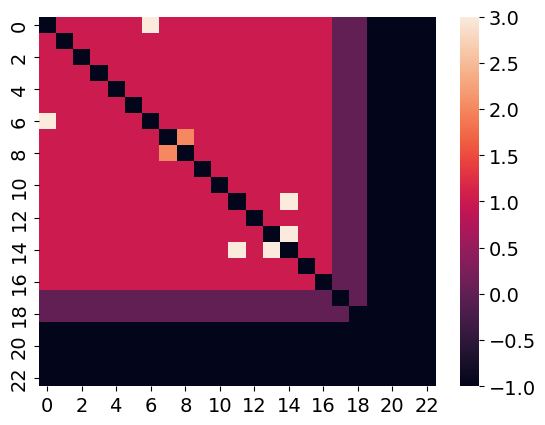

In [23]:
sns.heatmap(dominant_types)

In [24]:
i, j = 7, 8
d, p, e = get_significant_type(grp_Ms, i, j)
d, p, e

(2,
 array([[0.   , 1.   , 1.   , 0.004, 0.001],
        [0.   , 0.   , 1.   , 0.003, 0.   ],
        [0.   , 0.   , 0.   , 0.001, 0.   ],
        [0.996, 0.997, 0.999, 0.   , 1.   ],
        [0.999, 1.   , 1.   , 0.   , 0.   ]]),
 array([[   0.        ,   -2.58599184, -144.56412713,    2.90699832,
            2.90699832],
        [   2.58599184,    0.        , -103.04959336,    2.78048958,
            2.78048958],
        [ 144.56412713,  103.04959336,    0.        ,  145.02183343,
          145.02183343],
        [  -2.90699832,   -2.78048958, -145.02183343,    0.        ,
                   nan],
        [  -2.90699832,   -2.78048958, -145.02183343,           nan,
            0.        ]]))

In [25]:
# plot pairwise relationship-type frequencies

In [26]:
def get_relationship_freqs(Ms, i, j):
    """Get subject-frequencies for block pair (i,j)"""
    return Ms[i, j, :, :]  # 5 x num_subs

def plot_relationships_per_pair(ax, freqs, relationship_types=None):
    sns.boxplot(
        freqs.T, ax=ax, 
        fliersize=0, color='grey', 
        fill=False, width=0.5
    )
    sns.stripplot(
        freqs.T, ax=ax, 
        color='grey', alpha=0.5,
        jitter=False, marker='o', size=5
    )

    ax.plot(range(5), freqs[:, 0], c='grey', alpha=0.3, label='animal')
    ax.plot(range(5), freqs[:, 1:], c='grey', alpha=0.3)

    mfs, ci = bootstrap([freqs[:, sub] for sub in range(freqs.shape[-1])])
    ax.plot(mfs, c='cornflowerblue', marker='o', linewidth=2, label='mean')
    ax.fill_between(
        range(5),
        ci[0],
        ci[1],
        color='cornflowerblue',
        alpha=0.3,
        label='95% CI'
    )

    ax.set_xticklabels(relationship_types)
    ax.set_ylim(0, 1)

    ax.legend()
    ax.grid(alpha=0.15)
    return None

def plot_comm_relationships(
        Ms, 
        dominant_types,
        relationship_types=['none', 'assort', '(c, p)', '(p, c)', 'bipart', 'none'], 
        relationship_colors=['white', 'azure', 'mistyrose', 'linen', 'lavender', 'white'],
        num_blocks=None,
    ):
    num_blocks = grp_Ms.shape[0] if num_blocks is None else num_blocks
    ncols = num_blocks
    nrows = num_blocks
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), dpi=120)
    fig.tight_layout(h_pad=3, w_pad=3)
    fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)

    for (i, j) in tqdm(list(np.ndindex(num_blocks, num_blocks))):
        ax = axs[i, j] if nrows > 1 else axs
        if i >= j: 
            fig.delaxes(ax)
            continue

        freqs = get_relationship_freqs(Ms, i, j)
        plot_relationships_per_pair(ax, freqs, relationship_types[:-1])
        
        ax.set_title(f'comm {j}', fontsize=14)
        ax.set_ylabel(f'comm {i}')

        dominant_type = int(dominant_types[i, j])
        color = relationship_colors[dominant_type]
        # for spine in ax.spines.values():
        #     spine.set_color(color)
        #     spine.set_linewidth(3)
        ax.set_facecolor(color)
        
        legend = ax.get_legend()
        box = legend.get_frame()
        ax.text(
            x=0.5, y=1.0-0.1, 
            s=relationship_types[dominant_type],
            transform=ax.transAxes,
            ha='center',
            bbox=dict(
                facecolor=color,
                edgecolor='black',
                boxstyle='round',
                alpha=0.3,
            ),
        )
    return fig

In [27]:
Ms = grp_Ms
relationship_types = ['none', 'assort', '(c, p)', '(p, c)', 'bipart', 'none']
relationship_colors = ['white', 'beige', 'mistyrose', 'lightcyan', 'lavender', 'white']
num_blocks = np.min([Ms[0].shape[0], 19])
fig = plot_comm_relationships(Ms, dominant_types, relationship_types, relationship_colors, num_blocks=num_blocks)
plt.close('all')

100%|██████████| 361/361 [00:28<00:00, 12.61it/s]


In [28]:
folder = f'{ESTIM_path}/group/community-interactions/{SBM}'
os.system(f'mkdir -p {folder}')

with open(f'{folder}/{col}_desc-comm-interactions.pkl', 'wb') as f:
    pickle.dump(grp_Ms, f)

with open(f'{folder}/{col}_desc-dominant-interactions.pkl', 'wb') as f:
    pickle.dump(dominant_types, f)

fig.savefig(f'{folder}/{col}_desc-interactions.pdf', bbox_inches='tight')